In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, LassoCV, ElasticNetCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import LeaveOneOut

In [13]:
# Load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [8]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


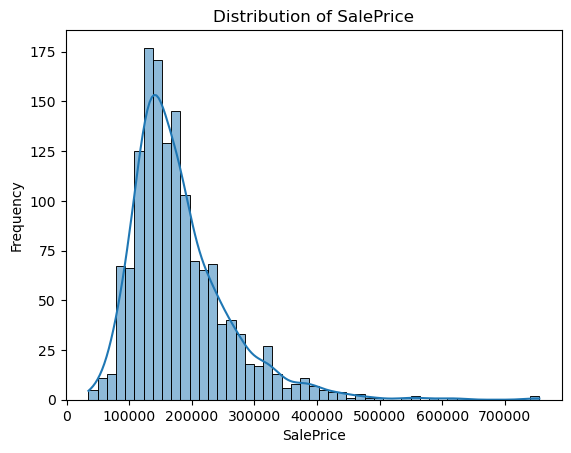

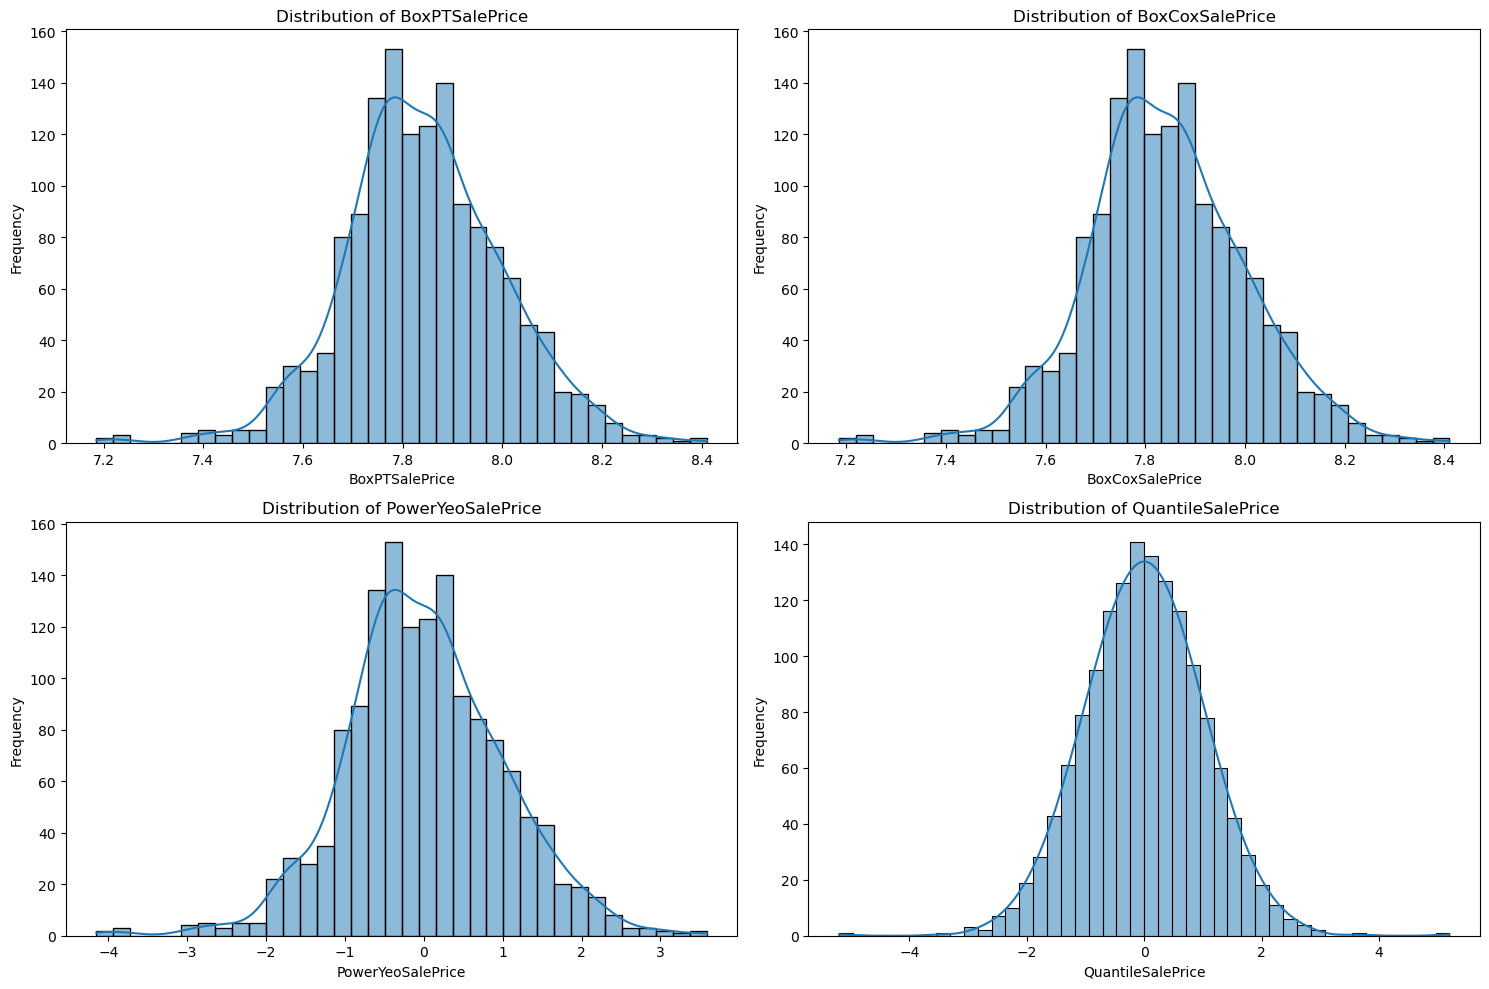

In [17]:
# Visualize the distribution of SalePrice
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Apply transformations to the target variable
ptb = PowerTransformer(method='box-cox', standardize=False)
pty = PowerTransformer(method='yeo-johnson', standardize=True)
qt = QuantileTransformer(output_distribution='normal')
train_data['BoxPTSalePrice'] = ptb.fit_transform(train_data[['SalePrice']])
train_data['BoxCoxSalePrice'], _ = stats.boxcox(train_data['SalePrice'])
train_data['PowerYeoSalePrice'] = pty.fit_transform(train_data[['SalePrice']])
train_data['QuantileSalePrice'] = qt.fit_transform(train_data[['SalePrice']])
transformations = ['BoxPTSalePrice', 'BoxCoxSalePrice', 'PowerYeoSalePrice', 'QuantileSalePrice']

# Visualize the distribution of transformed SalePrice variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(transformations, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [18]:

# Fill missing values
for col in train_data.select_dtypes(include=[np.number]).columns:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(train_data[col].median())

for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Encode categorical variables
label_encoders = {}
for col in train_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col].astype(str))
    label_encoders[col] = le

# Prepare the data
transformations = ['SalePrice', 'BoxPTSalePrice', 'BoxCoxSalePrice', 'PowerYeoSalePrice', 'QuantileSalePrice']
X = train_data.drop(transformations, axis=1)

# Function to evaluate models
def evaluate_model(target_column, model):
    y = train_data[target_column]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

model_dict = {
    'LR': LinearRegression(),
    'SGD': SGDRegressor(),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV()
}

model_results = {}

# Evaluate each model
for model_name, model in model_dict.items():
    print(f"RMSE for {model_name}:")
    # print("-"*20)
    # Evaluate each transformation
    trans_results = {}
    for col in transformations:
        rmse = evaluate_model(col, model)
        trans_results[col] = round(rmse, 6)  # round rmse
        # print(f"{col}: {rmse}")
        
    model_results[model_name] = trans_results
    # print("")

print(model_results)

results_df = pd.DataFrame(model_results)

results_df

# # Evaluate each transformation
# results = {}
# for col in transformations:
#     rmse = evaluate_model(col)
#     results[col] = rmse

# # Display RMSE for each transformation
# print("RMSE for each transformation:")
# for key, value in results.items():
#     print(f"{key}: {value}")

RMSE for LR:
RMSE for SGD:
RMSE for LassoCV:
RMSE for ElasticNetCV:
RMSE for RidgeCV:
{'LR': {'SalePrice': 35344.207069, 'BoxPTSalePrice': 0.062849, 'BoxCoxSalePrice': 0.062849, 'PowerYeoSalePrice': 0.39727, 'QuantileSalePrice': 0.379998}, 'SGD': {'SalePrice': 1.0347763049622254e+17, 'BoxPTSalePrice': 1.5264499604813786e+17, 'BoxCoxSalePrice': 6.468337057710789e+16, 'PowerYeoSalePrice': 1.12507836574087e+17, 'QuantileSalePrice': 9.726412794088693e+16}, 'LassoCV': {'SalePrice': 41813.923451, 'BoxPTSalePrice': 0.078548, 'BoxCoxSalePrice': 0.078548, 'PowerYeoSalePrice': 0.496497, 'QuantileSalePrice': 0.476015}, 'ElasticNetCV': {'SalePrice': 54535.408314, 'BoxPTSalePrice': 0.078551, 'BoxCoxSalePrice': 0.078551, 'PowerYeoSalePrice': 0.496624, 'QuantileSalePrice': 0.476151}, 'RidgeCV': {'SalePrice': 34389.49033, 'BoxPTSalePrice': 0.062322, 'BoxCoxSalePrice': 0.062322, 'PowerYeoSalePrice': 0.393937, 'QuantileSalePrice': 0.376648}}


,LR,SGD,LassoCV,ElasticNetCV,RidgeCV
SalePrice,35344.207069,1.034776e+17,41813.923451,54535.408314,34389.490330
BoxPTSalePrice,0.062849,1.526450e+17,0.078548,0.078551,0.062322
BoxCoxSalePrice,0.062849,6.468337e+16,0.078548,0.078551,0.062322
PowerYeoSalePrice,0.397270,1.125078e+17,0.496497,0.496624,0.393937
QuantileSalePrice,0.379998,9.726413e+16,0.476015,0.476151,0.376648


In [14]:
# Load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# Fill missing values
for col in train_data.select_dtypes(include=[np.number]).columns:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(train_data[col].median())

for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Encode categorical variables
label_encoders = {}
for col in train_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col].astype(str))
    label_encoders[col] = le

# Apply Box-Cox Transformation
train_data['BoxCoxSalePrice'], _ = stats.boxcox(train_data['SalePrice'])

# Prepare the data
X_train = train_data.drop(['SalePrice', 'BoxCoxSalePrice'], axis=1)
y_train = train_data['BoxCoxSalePrice']
X_test = test_data.copy()

# Ensure the test data has the same columns as the training data
X_test = X_test[X_train.columns]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adding new features
train_data['YrBltAndRemod'] = train_data['YearBuilt'] + train_data['YearRemodAdd']
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
train_data['Total_sqr_footage'] = (train_data['BsmtFinSF1'] + train_data['BsmtFinSF2'] +
                                   train_data['1stFlrSF'] + train_data['2ndFlrSF'])
train_data['Total_Bathrooms'] = (train_data['FullBath'] + (0.5 * train_data['HalfBath']) +
                                 train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath']))
train_data['Total_porch_sf'] = (train_data['OpenPorchSF'] + train_data['3SsnPorch'] +
                                train_data['EnclosedPorch'] + train_data['ScreenPorch'] +
                                train_data['WoodDeckSF'])



The correlation heatmap shows strong positive correlations between BoxCoxSalePrice and features like OverallQual, GrLivArea, GarageCars, and TotalBsmtSF. These features are crucial predictors for house prices, indicating higher quality, larger living areas, and more garage space are strongly linked to higher sale prices.

In [17]:
# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_train_pred_lr = lr_model.predict(X_train_scaled)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))

# Train and evaluate SGDRegressor model
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train_scaled, y_train)
y_train_pred_sgd = sgd_model.predict(X_train_scaled)
train_rmse_sgd = np.sqrt(mean_squared_error(y_train, y_train_pred_sgd))

print(f'Linear Regression RMSE on Training Set: {train_rmse_lr}')
print(f'SGD Regressor RMSE on Training Set: {train_rmse_sgd}')

# Select the better model
best_model = lr_model if train_rmse_lr < train_rmse_sgd else sgd_model

# Predict on the test set using the best model
test_pred = best_model.predict(X_test_scaled)

# Handle infinite values
test_pred = np.where(np.isinf(test_pred), np.nan, test_pred)
test_pred = np.where(np.isnan(test_pred), np.nanmedian(test_pred), test_pred)

# Transform predictions back to the original scale
test_pred_original_scale = np.expm1(test_pred)  # Inverse of Box-Cox transformation

# Ensure no infinite or NaN values in the predictions
test_pred_original_scale = np.where(np.isinf(test_pred_original_scale), np.nan, test_pred_original_scale)
test_pred_original_scale = np.where(np.isnan(test_pred_original_scale), np.nanmedian(test_pred_original_scale), test_pred_original_scale)

# Prepare submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_pred_original_scale
})
# submission.to_csv('submission.csv', index=False)
# print('Submission file created successfully!')

Linear Regression RMSE on Training Set: 0.05355306678611071
SGD Regressor RMSE on Training Set: 0.05457415118047124
